In [ ]:
# import 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import count
plt.rcParams["figure.figsize"] = (14,8)


In [ ]:
def build_multi_graph(num_individuals, states, relationships, pU, pA, pP, p_physical, p_virtual, physical_weight, virtual_weight, influencers, influencer_weight, edge_multiplier):
  G = nx.MultiGraph()
  # for each node (individual) in network...
  for i in range(num_individuals):
    # determine random state of individual
    rand_state = np.random.choice(range(len(states)), 1, p=[pU, pA, pP])[0]
    # add node to graoh wiht that random state
    G.add_node(i, state = states[rand_state])

  # adding edges (setting relationships between individuals)
  for i in range(num_individuals*edge_multiplier):
    # select 2 random individuals (indices) from the population
    u = np.random.choice(range(num_individuals))
    v = np.random.choice(range(num_individuals))

    relationship = relationships[np.random.choice([0, 1], 1, p=[p_physical, p_virtual])[0]] # how should individuals be connected
    if relationship == 'Physical':
      weight = physical_weight
    else:
      weight = virtual_weight
    if u != v and not(G.has_edge(u, v)):
      G.add_weighted_edges_from([(u,v,weight)], relationsip=relationship)
    elif u != v and G.has_edge(u, v):
      relation = list(list(G.get_edge_data(u,v).values())[0].values())[0]
      set_A = set(relationships)
      set_B = {relation}
      relationship = set_A.difference(set_B).pop()
      G.add_weighted_edges_from([(u,v,weight)], relationsip=relationship)
    else:
      pass
    

  # randomly select 'influencer' nodes
  for influencer in range(influencers):
    random_influencer = np.random.randint(0, num_individuals)
    G.nodes[random_influencer]['state'] = 'Participant'
    # TO DO: determine range of num connections an influencer should have
    num_connections = np.random.randint(int(num_individuals/2.5), num_individuals/1.25)
    for i in range(num_connections):
      random_connection = np.random.randint(0, num_individuals)
      if random_connection != random_influencer: # influencers aren't influenced by themselves
        G.add_weighted_edges_from([(random_influencer,random_connection,influencer_weight)], relationsip=relationships[np.random.choice([0, 1], 1, p=[p_physical, p_virtual])[0]])

  return G


  

In [ ]:
def draw_graph(G):
  # coloring nodes by unique state with no control over color-state matching
  groups = set(nx.get_node_attributes(G,'state').values())
  mapping = dict(zip(sorted(groups),count()))
  node_colors = [mapping[G.nodes[n]['state']] for n in G.nodes()]

  edge_colors = nx.get_edge_attributes(G,'relationship').values()
  edge_colors=list(edge_colors)
  d = dict([(y,x+1) for x,y in enumerate(sorted(set(edge_colors)))])
  edge_colors = [d[x] for x in edge_colors]
  nx.draw(G, with_labels=False, node_size=150, pos=nx.fruchterman_reingold_layout(G), node_color=node_colors, edge_color=edge_colors,cmap=plt.cm.Spectral_r)


In [ ]:
def get_weighted_influence(neighbor_states, edge_weights):
  prob_aware = np.sum(edge_weights[np.where(neighbor_states == 'Aware')])/sum(edge_weights)
  prob_unaware = np.sum(edge_weights[np.where(neighbor_states == 'Unaware')])/sum(edge_weights) 
  prob_participant = np.sum(edge_weights[np.where(neighbor_states == 'Participant')])/sum(edge_weights)

  return prob_unaware, prob_aware, prob_participant

In [ ]:
# New Complex Voter Model
def run_complex_voter_model(T, G):
  res = []
  trend_popularity = count_states(G)[2]/G.number_of_nodes()
  for t in range(T):
    # choose random node and state to start
    rand_node = np.random.randint(0, len(G.nodes()))
    rand_node_state = G.nodes[rand_node]['state']
    neighbor_states = np.array([])
    edge_weights = np.array([])
    # shift preferences
    for neighbor in G.neighbors(rand_node):
      neighbor_state = G.nodes[neighbor]['state']
      edge_weight = G.get_edge_data(rand_node, neighbor)[0]['weight']
      # if the neighbor is a participant, their influence is increased by a factor of the current(updating) trend popularity
      if neighbor_state == 'Participating':
        edge_weight = edge_weight*(1+trend_popularity)
      neighbor_states = np.append(neighbor_states, neighbor_state)
      edge_weights = np.append(edge_weights, edge_weight)
    if rand_node_state == 'Aware' or rand_node_state == 'Participant':
      edge_weights = np.delete(edge_weights,np.where(neighbor_states ==  'Unaware'))
      neighbor_states = [value for value in neighbor_states if value != 'Unaware']
      
    if len(neighbor_states) != 0:
      prob_unaware, prob_aware, prob_participant = get_weighted_influence(np.array(neighbor_states), edge_weights)
      rand_state = np.random.choice(['Unaware', 'Aware', 'Participant'], 1, p=[prob_unaware, prob_aware, prob_participant])

    elif len(neighbor_states) == 0:
      rand_state = rand_node_state

    G.nodes[rand_node]['state'] = rand_state
    unaware_counter, aware_counter, participant_counter = count_states(G)
    res.append((unaware_counter, aware_counter, participant_counter))
    trend_popularity = count_states(G)[2]/G.number_of_nodes()
  return G, res
  


In [ ]:
# Initial Model
def run_voter_model(T, G):
  res = []
  for t in range(T):
    # choose random node and state to start
    rand_node = np.random.randint(0, len(G.nodes()))
    rand_node_state = G.nodes[rand_node]['state']
    neighbor_states = np.array([])

    # shift preferences
    for neighbor in G.neighbors(rand_node):
      neighbor_state = G.nodes[neighbor]['state']
      neighbor_states=np.append(neighbor_states,neighbor_state)
    if rand_node_state == 'Aware' or rand_node_state == 'Participant':
      neighbor_states = [value for value in neighbor_states if value != 'Unaware']
    if len(neighbor_states) == 0:
      neighbor_states = np.append(neighbor_states, rand_node_state)
  
    
    rand_state = np.random.randint(0, len(neighbor_states))
    G.nodes[rand_node]['state'] = neighbor_states[rand_state]
    unaware_counter, aware_counter, participant_counter = count_states(G)
    res.append((unaware_counter, aware_counter, participant_counter))
  return G, res
  


In [ ]:
def count_states(G):
  # get population information
  unaware_counter = 0
  aware_counter = 0 
  participant_counter = 0
  node_states = list(G.nodes(data='state'))
  for i in range(len(node_states)):
    node_state = list(G.nodes(data='state'))[i][1]
    if node_state == 'Unaware':
      unaware_counter+=1
    if node_state == 'Aware':
      aware_counter+=1
    if node_state == 'Participant':
      participant_counter+=1

  return unaware_counter, aware_counter, participant_counter
  


In [ ]:
def build_model(time_period):

  num_individuals = 200
  relationships = ['Physical', 'Virtual']
  states = ['Unaware', 'Aware', 'Participant']

  pU = .8
  pA = .15
  pP = .05


  if time_period == 'Pre':
    p_physical = .9
    p_virtual = .1
    influencers = 1
    edge_multiplier = 3
    virtual_weight = 1
    physical_weight = 4
    influencer_weight = 6
  if time_period == 'Beginning':
    p_physical = .6
    p_virtual = .4
    influencers = 6
    edge_multiplier = 4
    virtual_weight = 4
    physical_weight = 4
    influencer_weight = 10
  if time_period == 'Current':
    p_physical = .3
    p_virtual = .7
    influencers = 20
    edge_multiplier = 5
    virtual_weight = 8
    physical_weight = 2
    influencer_weight = 30

  G = build_multi_graph(num_individuals, states, relationships, pU, pA, pP, p_physical, p_virtual, physical_weight, virtual_weight, influencers, influencer_weight, edge_multiplier)
  return G

  


Test Different Networks


In [ ]:
t1 = 'Pre'
t2 = 'Beginning'
t3 = 'Current'

In [ ]:
G = build_model(t3)

100
128
189
15
186
46
112
14
158
142
87
150
20
129
114
154
66
4
129
65


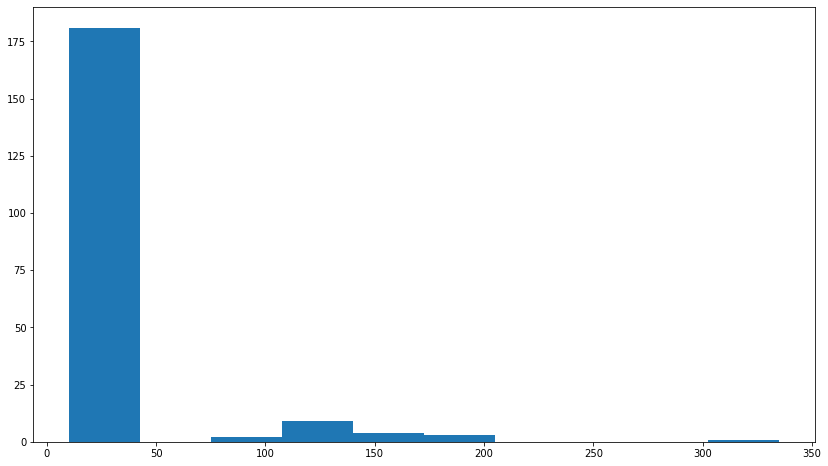

In [ ]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

plot_degree_dist(G)

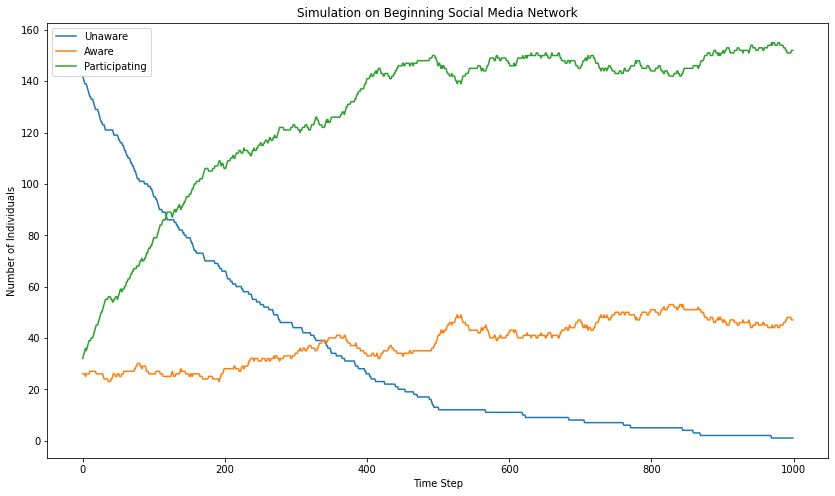

In [ ]:
plt.rcParams["figure.figsize"] = (14,8)
T = 1000
G, res = run_complex_voter_model(T, G)
U, A, P = map(np.array, zip(*res))
plt.plot(np.arange(0, T, 1), U, label = 'Unaware')
plt.plot(np.arange(0, T, 1), A, label = 'Aware')
plt.plot(np.arange(0, T, 1), P, label = 'Participating')
plt.xlabel('Time Step')
plt.ylabel('Number of Individuals')
plt.title('Simulation on Beginning Social Media Network')
plt.legend()